In [2]:
# !pip install "torch==1.4" "torchvision==0.5.0"

In [1]:
%load_ext autoreload 
%autoreload 2
%matplotlib inline

# Import Libraries

In [2]:
from fastai.vision import *
from fastai.imports import *

# Look At The Data! 

In [3]:
%cd /content/

/content


In [4]:
# !mkdir masks 
# !unzip 2d_masks.zip.zip
# !mv 2d_masks.zip masks
# !rm 2d_masks.zip.zip
# %cd masks 
# !unzip 2d_masks.zip
# !rm 2d_masks.zip

In [5]:
%cd ../

/


In [10]:
# !mkdir images
# !unzip 2d_images.zip.zip
# !mv 2d_images.zip images
# !rm 2d_images.zip.zip
# %cd images 
# !unzip 2d_images.zip
# !rm 2d_images.zip

In [11]:
%cd ../

/content


In [12]:
# !mkdir lungs 
# !mv images lungs
# !mv masks lungs

In [5]:
path = Path('/content/lungs')

In [6]:
img_path = path/'images'
lbl_path = path/'masks'

In [7]:
fnames = get_image_files(img_path)
labels = get_image_files(lbl_path)

In [8]:
fnames[:3]

[PosixPath('/content/lungs/images/ID_0145_Z_0059.tif'),
 PosixPath('/content/lungs/images/ID_0159_Z_0104.tif'),
 PosixPath('/content/lungs/images/ID_0025_Z_0112.tif')]

In [9]:
labels[:3]

[PosixPath('/content/lungs/masks/ID_0145_Z_0059.tif'),
 PosixPath('/content/lungs/masks/ID_0159_Z_0104.tif'),
 PosixPath('/content/lungs/masks/ID_0025_Z_0112.tif')]

In [10]:
len(fnames) == len(labels)

True

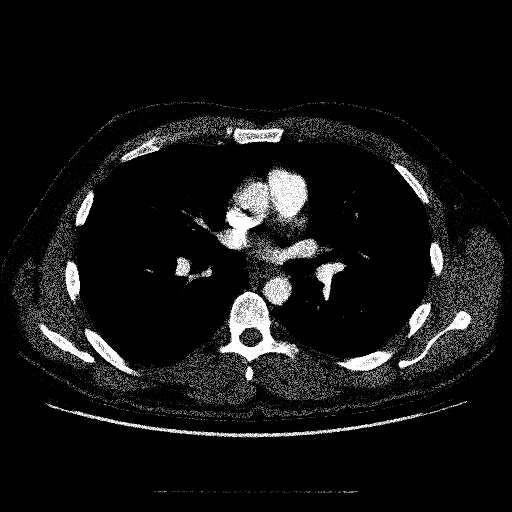

In [11]:
img_f = fnames[0]
img = open_image(img_f)
img

In [12]:
get_y_fnc = lambda x: lbl_path/f'{x.stem}{x.suffix}'

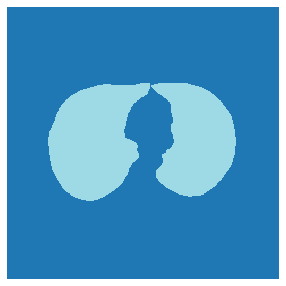

In [13]:
mask = open_mask(get_y_fnc(img_f))
mask.show(figsize=(5,5), alpha=1)

In [14]:
src_size = np.array(mask.shape[1:]) #we want to open first image in the mask 
src_size,mask.data

(array([512, 512]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [15]:
size = src_size//4
bs = 8

In [16]:
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)
    
class SegItemListCustom(ImageList):
    _label_cls = SegLabelListCustom

In [17]:
np.random.seed(42)
src = (SegItemListCustom.from_folder(img_path)  
       .split_by_rand_pct(0.2)
       .label_from_func(get_y_fnc, classes=['1','0']))

In [18]:
data = (src.transform(get_transforms(), size = size,tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

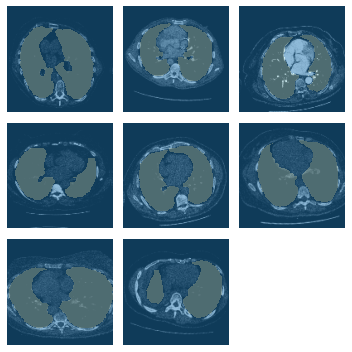

In [19]:
data.show_batch(3, figsize = (5,5))

In [20]:
def dice(input:Tensor, targs:Tensor, iou:bool=False)->Rank0Tensor:
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    intersect = (input * targs).sum().float()
    union = (input+targs).sum().float()
    if not iou: return (2. * intersect / union if union > 0 else union.new([1.]).squeeze())
    else: return intersect / (union-intersect+1.0)

In [21]:
learn = unet_learner(data, models.resnet50, metrics = dice, wd = 1e-02)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


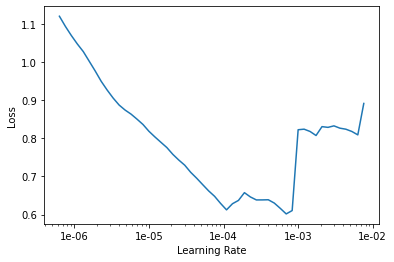

In [22]:
learn.lr_find()
learn.recorder.plot()

In [23]:
lr = 1e-05

In [24]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,dice,time
0,0.738545,0.643049,0.515589,00:26
1,0.478844,0.135120,0.895860,00:24
2,0.306616,0.083087,0.937394,00:24
3,0.210027,0.067402,0.941984,00:24
4,0.160854,0.070427,0.946291,00:24
5,0.130740,0.056605,0.953345,00:24
6,0.114420,0.068343,0.947440,00:24
7,0.102540,0.062014,0.951124,00:24
8,0.093304,0.054806,0.955742,00:24
9,0.087705,0.055011,0.955581,00:24


In [25]:
learn.save('model-1')

In [20]:
# learn.load('model-1');

In [26]:
learn.unfreeze() 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


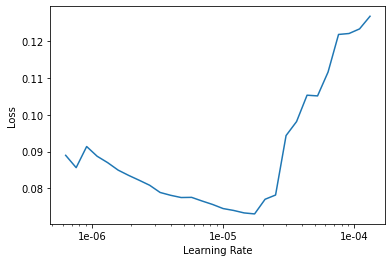

In [27]:
learn.lr_find()
learn.recorder.plot()

In [28]:
# learn.load('model-1')
learn.fit_one_cycle(10, slice(1e-06, lr/5))

epoch,train_loss,valid_loss,dice,time
0,0.076521,0.054450,0.954480,00:24
1,0.077796,0.053430,0.955759,00:24
2,0.076166,0.051868,0.955303,00:24
3,0.079000,0.051267,0.957355,00:24
4,0.077250,0.054265,0.956080,00:24
5,0.077120,0.050741,0.958627,00:24
6,0.074806,0.051258,0.958793,00:24
7,0.072698,0.048986,0.959308,00:24
8,0.071076,0.048942,0.959335,00:24
9,0.069112,0.049377,0.958987,00:24


In [29]:
learn.save('model-2')

In [ ]:
# learn.load('model-2');

In [30]:
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [32]:
learn.destroy()

size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this object has been destroyed
using bs=3, have 14275MB of GPU RAM free


In [33]:
data = (src.transform(get_transforms(), size = size,tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [34]:
learn = unet_learner(data, models.resnet50, metrics = dice, wd = 1e-02).to_fp16()

In [35]:
learn.load('model-2');

epoch,train_loss,valid_loss,dice,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


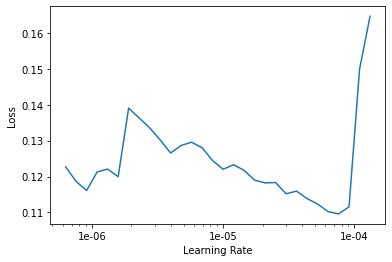

In [36]:
learn.lr_find()
learn.recorder.plot()

In [37]:
lr = 1e-04/2

In [39]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,dice,time
0,0.085853,0.041590,0.965126,00:56
1,0.092816,0.055802,0.954572,00:52
2,0.108541,0.063313,0.960763,00:52
3,0.088948,0.033425,0.972841,00:52
4,0.069311,0.030860,0.973908,00:52
5,0.068010,0.032518,0.973152,00:52
6,0.058356,0.029628,0.975385,00:51
7,0.059701,0.035973,0.974421,00:51
8,0.053949,0.029406,0.976767,00:52
9,0.043770,0.029318,0.976706,00:52


In [40]:
learn.save('model-1-big')

In [27]:
learn.load('model-1-big');

In [41]:
learn.unfreeze()

epoch,train_loss,valid_loss,dice,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


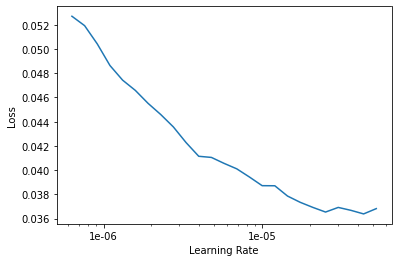

In [42]:
learn.lr_find()
learn.recorder.plot()

In [43]:
learn.fit_one_cycle(10, slice(1e-06, lr/5))

epoch,train_loss,valid_loss,dice,time
0,0.043700,0.028567,0.976730,00:54
1,0.040618,0.027754,0.976362,00:53
2,0.055883,0.040119,0.971904,00:53
3,0.051727,0.028188,0.975893,00:53
4,0.043565,0.026376,0.976742,00:53
5,0.046252,0.028699,0.976494,00:53
6,0.046316,0.027719,0.977314,00:53
7,0.040663,0.027959,0.976647,00:53
8,0.035733,0.026590,0.977328,00:53
9,0.038822,0.026173,0.977568,00:53


In [44]:
learn.save('model-2-big')

In [50]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=1, have 4529MB of GPU RAM free


In [55]:
data = (src.transform(get_transforms(), size = size//2,tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [56]:
learn = unet_learner(data, models.resnet50, metrics = dice, wd = 1e-02).to_fp16()

In [58]:
# learn.load('model-2-big')

In [59]:
preds, y = learn.get_preds()
predicted_masks = np.argmax(preds, axis = 1)

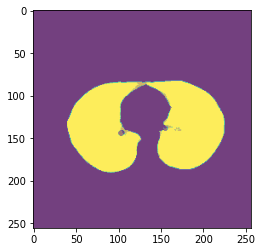

In [65]:
a = predicted_masks[0]
b = data.valid_ds[0][1].data
b.unsqueeze_(-1)
b = b.reshape(256, 256)
plt.imshow(a, alpha = 0.5)
plt.imshow(b, alpha = 0.5)
plt.show()

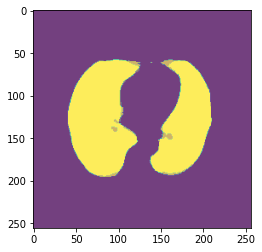

In [66]:
a = predicted_masks[1]
b = data.valid_ds[1][1].data
b.unsqueeze_(-1)
b = b.reshape(256, 256)
plt.imshow(b, alpha = 0.5)
plt.imshow(a, alpha = 0.5)
plt.show()

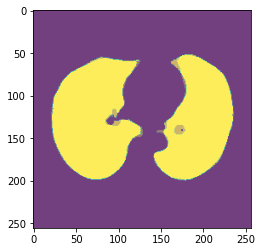

In [67]:
a = predicted_masks[2]
b = data.valid_ds[2][1].data
b.unsqueeze_(-1)
b = b.reshape(256, 256)
plt.imshow(b, alpha = 0.5)
plt.imshow(a, alpha = 0.5)
plt.show()